# Modeling a roulette wheel in vanilla Python

## Why are you doing this?

I was recently informed that there is an entire ecosystem of roulette strategy videos on YouTube.  Many of them seem to be variations on martingale, but not quite all.  I thought it might be fun to investigate modeling a few of these strategies in Python.  

Since comprehensibility is important, I wanted to do it in vanilla Python.  If I primarily cared about speed or nice output formatting I'd use pandas.  However, note that Pandas doesn't do as well when evaluating arbitrary user functions or when adding rows to a table one at a time.  Impelmenting these strategies efficiently in pandas would mean making them look much less like they'd play at the table.

## What did you learn?

### About Jupyter Notebooks

Jupyter's mixing of code and prose often works very well, but a simulation like this really benefits from classes and Jupyter's style conflicts with that.  Since classes are defined in a single block of code, there can't be any markdown blocks within them.  There are ways to add methods to classes after they've been created but they're all against the idiom and much harder to read.

### About the simulation

The hardest part by far was figuring out how to present the data.  Eventually I decided that since all the strategies will eventually go broke, the best thing to model was how long that takes.  Specifically, what proportion of the time will players using a given strategy fail to reach a given number of spins before they run out of money.

All the strategies modeled make one of the best with the best odds, specifically bets on a color.  Given that, the way to play the most spins on average is, unsurprisingly, to always make the minimum bet.

The data was hard to display because, while the martingale systems often run out of money shockingly fast, a small proportion of the time they play for a very long time.  This means there are a few spin counts that occur most often and a very wide range of higher values that only occur once or twice, which makes scaling the graph to show any detail very difficult.  I ventaully decided to ony show the first .8 to .95 of the cumulative probability distribution since that answers the question - How long will I get to play - pretty well.

## Simulation

### The Game

#### The Wheel

The places where the ball can settle are called "pockets."  American roulette has two green pockets call "0" and "00."  I'm going to lazily label the double zero pocket as -1 for now.  The rest of the pockets are evenly (though irregularly) divided between red and black.

If I were going to use this more widely, I'd probably model at least the color as an enum, and the pockets as a NamedTuple if not an enum themselves.

In [727]:
from random import choice
import itertools
from collections import Counter

In [728]:
class RouletteWheel:
    POCKETS =(
        (-1, 'green'),
        (0, 'green'),
        (1, 'red'),
        (2, 'black'),
        (3, 'red'),
        (4, 'black'),
        (5, 'red'),
        (6, 'black'),
        (7, 'red'),
        (8, 'black'),
        (9, 'red'),
        (10, 'black'),
        (11, 'black'),
        (12, 'red'),
        (13, 'black'),
        (14, 'red'),
        (15, 'black'),
        (16, 'red'),
        (17, 'black'),
        (18, 'red'),
        (19, 'red'),
        (20, 'black'),
        (21, 'red'),
        (22, 'black'),
        (23, 'red'),
        (24, 'black'),
        (25, 'red'),
        (26, 'black'),
        (27, 'red'),
        (28, 'black'),
        (29, 'black'),
        (30, 'red'),
        (31, 'black'),
        (32, 'red'),
        (33, 'black'),
        (34, 'red'),
        (35, 'black'),
        (36, 'red'))
    
    def spin(self):
        return choice(self.POCKETS)

##### Demonstrate and test the wheel

Here's an example of calling `random.choice()` with the `POCKETS` we defined above.

In [729]:
theWheel = RouletteWheel()
print(
    theWheel.spin(),
    theWheel.spin(),
    theWheel.spin(),)

(29, 'black') (5, 'red') (8, 'black')


To create a little more confidence that the wheel is fair, let's spin it many times and graph the results.  Each pocket should be about equally likely.

In [730]:
from collections import Counter

In [731]:
million_spins = tuple(theWheel.spin() for _ in range(1_000_000))
million_spins = sorted(Counter(million_spins).items())

In [732]:
import matplotlib.pyplot as plt

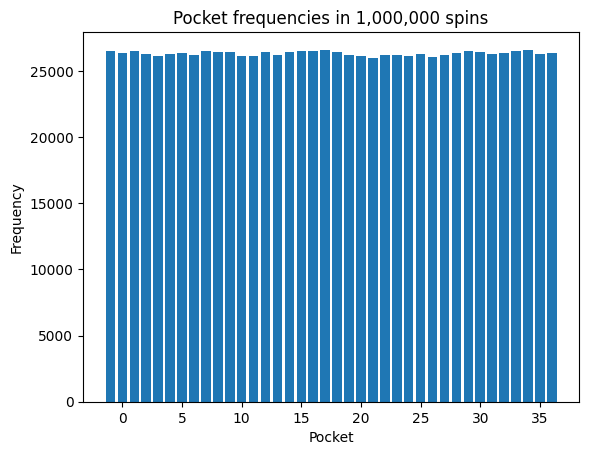

In [733]:
fig, ax = plt.subplots()
ax.bar([pocket[0][0] for pocket in million_spins], [pocket[1] for pocket in million_spins])
ax.set_title("Pocket frequencies in 1,000,000 spins")
ax.set_xlabel("Pocket")
ax.set_ylabel("Frequency")
plt.show()

That seems relatively uniform to me.

#### The Table

Multiple players can play the same roulette table simultaneously.  I originally wanted to show multiple players with different strategies playing the same table, so I bult this.  Unfortuantely, since I'm doing aggregate analysis of many, many runs, it's just simpler to have each player sitting at the table by themselves.  But this is the table the strategies were built to use, so it's still here.

It's the wheel that keeps track of the history of spins.  It also notifies each player of the results and runs until they've all quit.  It can provide a list of players so they can be asked about their own histories.  This means player objects aren't easily reuseable and you just need to make new ones for each table.

In [734]:
class RouletteTable:
    def __init__(self) -> None:
        self.wheel = RouletteWheel()
        self.wheel_history = list()
        self.players = set()
        self.live_players = set()
    
    def add_player(self, player):
        self.players.add(player)
        self.live_players.add(player)
    
    def round(self):
        winning_pocket = self.wheel.spin()
        for player in self.live_players:
            player.inform(winning_pocket, self.wheel_history)
        self.wheel_history.append(winning_pocket)
    
    def play(self):
        while self.live_players:
            self.round()
            self.live_players = {player for player in self.live_players if player.alive()}
    
    def get_history(self):
        return self.wheel_history
    
    def get_players(self):
        return self.players

#### The Players

The strategy classes implement a common interface.  There's one that always makes a minimum bet on Red, one that always makes a minimum bet on black, and two based on YouTube videos that rolled across my Facebook at some point.

In [735]:
class AlwaysRed:
    def __init__(self, starting_funds = 100, minimum_bet = 3) -> None:
        self.funds = starting_funds
        self.history = list()
        self.bet = minimum_bet
    
    def inform(self, pocket, table_history):
        number, color = pocket
        bet = min(self.bet, self.funds)
        if color == "red":
            winnings = bet
        else:
            winnings = -bet
        self.funds += winnings
        self.history.append(("AlwaysRed", "red", winnings, self.funds))
    
    def alive(self):
        return self.funds > 0

    def get_history(self):
        return self.history



In [736]:
class AlwaysBlack:
    def __init__(self, starting_funds = 100, minimum_bet = 3) -> None:
        self.funds = starting_funds
        self.history = list()
        self.bet = minimum_bet
    
    def inform(self, pocket, table_history):
        number, color = pocket
        bet = min(self.bet, self.funds)
        if color == "black":
            winnings = bet
        else:
            winnings = -bet
        self.funds += winnings
        self.history.append(("AlwaysBlack", "black", bet, winnings, self.funds))
    
    def alive(self):
        return self.funds > 0

    def get_history(self):
        return self.history



The strategy below comes from this video: [Martingale Chase](https://youtu.be/_72pAe_Wqw8)

In [737]:
class MartingaleChase:
    def __init__(self, starting_funds = 100, minimum_bet = 3, starting_color = "black", quit_on_loss = False) -> None:
        self.starting_bet = minimum_bet
        self.current_bet = minimum_bet
        self.funds = starting_funds
        self.last_seen_winning_color = starting_color
        self.history = list()
        self.early_quit = quit_on_loss
        self.quit = False
    
    def inform(self, pocket, table_history):
        winning_number, winning_color = pocket
        bet_color = self.last_seen_winning_color
        if (self.early_quit and self.current_bet > self.funds) or self.funds == 0:
            self.quit = True
        bet = min(self.current_bet, self.funds) if not self.quit else 0
        if winning_color == bet_color:
            winnings = bet
            self.current_bet = self.starting_bet
        else:
            winnings = -bet
            self.current_bet += self.current_bet
        self.funds += winnings
        self.history.append(("MartingaleChase", bet_color, bet, winnings, self.funds))
        if winning_color != 'green':
            self.last_seen_winning_color = winning_color
    
    def get_history(self):
        return self.history
    
    def alive(self):
        return not self.quit

The video doesn't name this strategy, so I will just name it after the channel [Makeshift](https://youtu.be/iR4wvKR1GUA)

In [738]:
class Makeshift:
    def __init__(self, starting_funds = 100, minimum_bet = 3, starting_color = "black", quit_on_loss = False) -> None:
        self.starting_bet = minimum_bet
        self.current_bet = minimum_bet
        self.funds = starting_funds
        self.starting_color = starting_color
        self.bet_color = starting_color
        self.history = list()
        self.early_quit = quit_on_loss
        self.quit = False
    
    def inform(self, pocket, table_history):
        winning_number, winning_color = pocket
        if (self.early_quit and self.current_bet > self.funds) or self.funds == 0:
            self.quit = True
        bet = min(self.current_bet, self.funds) if not self.quit else 0
        bet_color = self.bet_color
        if winning_color == bet_color:
            winnings = bet
            self.current_bet = self.starting_bet
            self.bet_color=self.starting_color
        else:
            winnings = -bet
            if self.bet_color == self.starting_color:
                self.bet_color = 'red' if self.starting_color == 'black' else 'black'
            else:
                self.current_bet += self.current_bet
        self.funds += winnings
        self.history.append(("Makeshift", bet_color, bet, winnings, self.funds))
    def get_history(self):
        return self.history
    
    def alive(self):
        return not self.quit

### The Data

Following is a method for sampling a strategy a large number of times.

In [739]:
def sample_strategy(strategy, iterations=10_000):
    res = list()
    for _ in range(iterations):
        myTable = RouletteTable()
        myPlayer = strategy()
        myTable.add_player(myPlayer)
        myTable.play()
        res.append(tuple(zip(myTable.get_history(), myPlayer.get_history())))
    return res

Now we make a dictionary of our strategies and all the samples we wanted to take.

In [740]:
strategy_samples = {
    "AlwaysRed": sample_strategy(AlwaysRed),
    "AlwaysBlack": sample_strategy(AlwaysBlack),
    "MartingaleChase": sample_strategy(MartingaleChase),
    "Makeshift": sample_strategy(Makeshift)
    }

The dictionary above starts out with spin-by-spin history for each run.  To graph the data we've got do some aggregation, so I reduce each sample from its entire history into how many spins it took the player to go broke.  Then, I use the `Counter` class to make a frequency table, how many samples ended at a given number of spins.

In [741]:
strategy_samples_run_lengths = {k: [len(i) for i in v] for k, v in strategy_samples.items() for i in v}
strategy_run_length_frequency_counters = {k: Counter(v) for k, v in strategy_samples_run_lengths.items()}

It's often more natural to talk about the _proportion_ of samples rather than the _count_ espeically when comparing things.  It's easier to say that something happend 25% of the time than 125/500 times, especially when comparing accross multiple distributions.  So here I normalize the frequency tables for each strategy.  That means I divide them by the number of samples, turning them into proportions that all together add up to 1.  Note that there's some very small floating point error here but it's accurate to at least 8 decimal places.

In [742]:
strategy_runs_normalized = {strat: sorted(((run, count/counter.total()) for run, count in counter.items())) for strat, counter in strategy_run_length_frequency_counters.items() }


I could try to graph the values above, but the number of players that went broke on exactly 9 spins, 10 spins, and 11 spins for example, aren't very useful by themselves.  I could try breaking the data into buckets instead, but I discuss why that doens't work very well at the very top of this post.  Instead, I think it's more natural to ask, what proportion of players make it to at least a given number of spins.  We'd answer that with a cumulative distribution, which I calculate below.

In [743]:
strategy_runs_cumulative = {strat: list(zip([run_len[0] for run_len in runs], itertools.accumulate([run_len[1] for run_len in runs]))) for strat, runs in strategy_runs_normalized.items()}

To make the graph more readable, and highlight the differences between strategies, below I trim off extreme results.  

In [744]:
strategy_runs_cumulative_trimmed = {k: [r for r in v if r[1] <= 0.85] for k, v in strategy_runs_cumulative.items()}

### The Graphs

Here's the code that makes the graph, which I will discuss below.

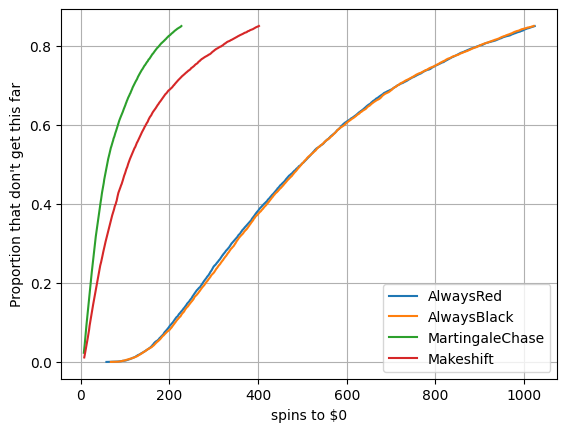

In [745]:
fig, ax = plt.subplots()

for k, v in strategy_runs_cumulative_trimmed.items():
    ax.plot([i[0] for i in v], [i[1] for i in v], label=str(k))
ax.grid(True)
ax.set_xlabel("spins to $0")
ax.set_ylabel("Proportion that don't get this far")
ax.legend()
plt.show()


The y axis on this graph is the proportion of players who have gone broke by the time they reach the corresponding number of spins on the x axis.  So for example, about 70% of players using the Makeshift strategy went broke by the 200th spin.

#### Does the graph look like we'd expect?

AlwaysRed and AlwaysBlack work as a sort of self-check here. Since both bets are equally likely, and they're always betting the same amount we'd expect them to perform very similarly, which we can see that they do.

The two martingale variants have very similar shapes, just shifted around.  The strategy from the Makeshift video tends to take longer to run out of money, this is because it doesn't start doubling the bet until the second loss, so the exponential grows more slowly.  

Why don't I graph just the martingale systems to get a closer look at them?

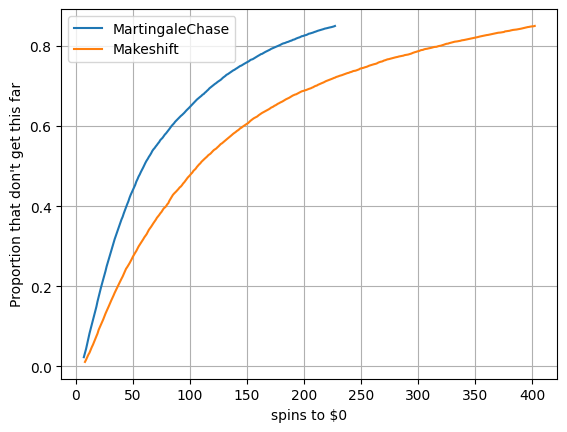

In [746]:
fig, ax = plt.subplots()

for k, v in strategy_runs_cumulative_trimmed.items():
    if k in {"Makeshift", "MartingaleChase"}:
        ax.plot([i[0] for i in v], [i[1] for i in v], label=str(k))
ax.grid(True)
ax.set_xlabel("spins to $0")
ax.set_ylabel("Proportion that don't get this far")
ax.legend()
plt.show()

It really stands out to me that using the strategy from the Makeshift video, you'll be going home after 50 spins or fewer about 25% of the time. Using the martingale chase strategy, you'll be going home after 28 spins or fewer about 25% of the time.

I did a little quick Googling to find out how many spins per hour there are at major casinos.  There's a lot of variability, but there are apparently as few as approximately 30 spins per hour at more sedate casinos and as many as approximately 55 at faster ones.  Electronic roulette machines can be very fast.  So, using these martingale strategies there's a solid chance you'll go broke in an hour or less.